In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
%matplotlib inline
from scipy.stats import norm, skew
from scipy import stats

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1460, 81)

In [5]:
test.shape

(1459, 80)

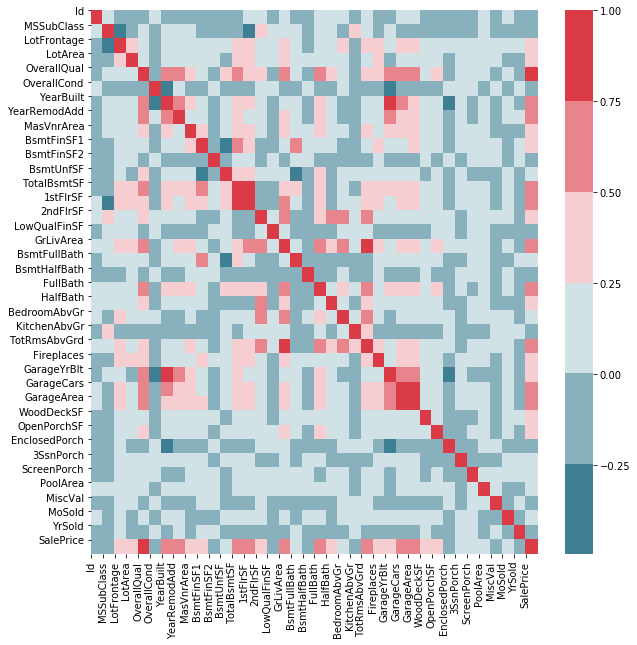

In [6]:
corr = train.corr()
fig, ax = plt.subplots(figsize = (10,10))
colormap = sns.diverging_palette(220, 10, as_cmap=False)
sns.heatmap(corr, cmap=colormap, fmt=".2f")
# sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

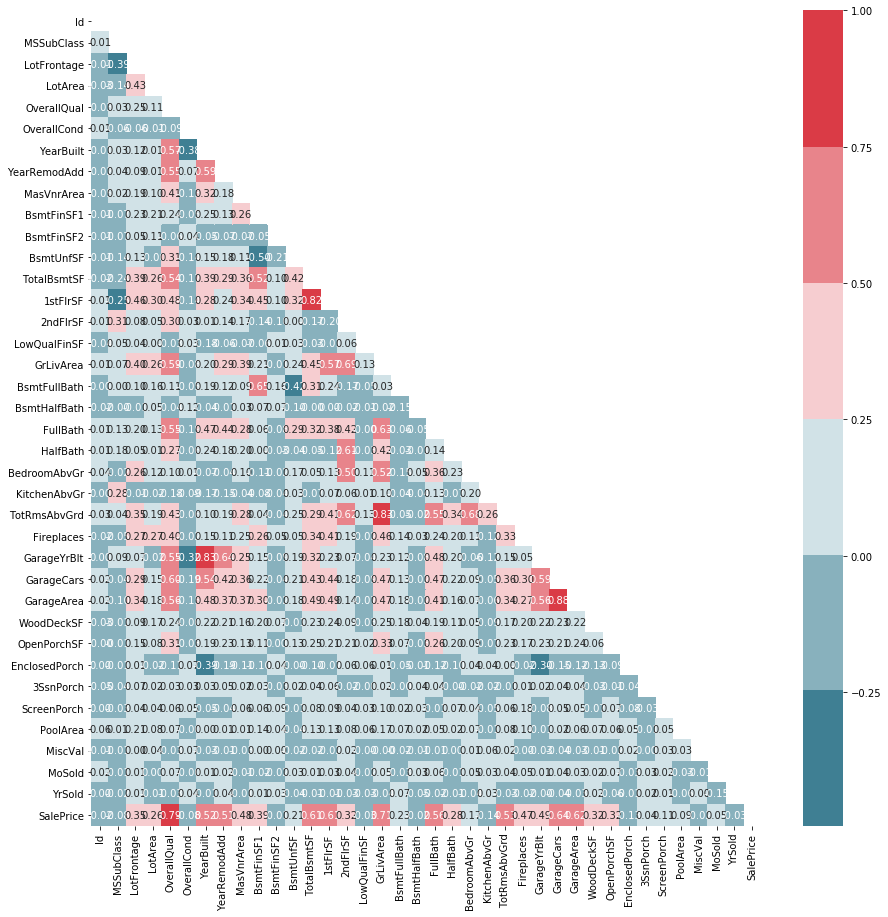

In [7]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap=colormap, annot = True,fmt=".2f", mask=mask)

In [8]:
test.shape
# test no sales price 

(1459, 80)

In [9]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [11]:
# Get the house_id from the test data set 
test_house_Id = test["Id"]


In [12]:
test_house_Id

0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [13]:
# Get SalePrice form train dataset 
y_train = train['SalePrice']

In [14]:
y_train

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [15]:
train =train.drop(columns =['Id'])

In [16]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [17]:
test =test.drop(columns =['Id'])

In [18]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [19]:
train.shape

(1460, 80)

In [20]:
ntrain = train.shape[0]
ntrain

1460

In [21]:
test.shape

(1459, 79)

In [22]:
ntest = test.shape[0]
ntest

1459

In [23]:
all_data = pd.concat((train,test)).reset_index (drop = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [24]:
all_data.shape

(2919, 80)

In [25]:
all_data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [26]:
all_data['total_SF'] = all_data['1stFlrSF']+all_data['2ndFlrSF']+all_data['TotalBsmtSF']

In [27]:
all_data['total_outdoor_sf']= all_data['3SsnPorch']+all_data['WoodDeckSF']+all_data['OpenPorchSF']+all_data['EnclosedPorch']+all_data['ScreenPorch']

In [28]:
all_data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [29]:
all_data = all_data.drop(columns = ['1stFlrSF','2ndFlrSF','TotalBsmtSF','3SsnPorch',
                                    'WoodDeckSF','OpenPorchSF','EnclosedPorch',
                                   'ScreenPorch'
                                   ])

In [30]:
all_data.columns

Index(['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir',
       'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual',
       'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces',
       'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle',
       'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea',
       'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass',
       'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal',
       'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive',
       'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SalePrice', 'SaleType', '

In [31]:
all_data.head()

,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,...,SalePrice,SaleType,Street,TotRmsAbvGrd,Utilities,YearBuilt,YearRemodAdd,YrSold,total_SF,total_outdoor_sf
0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,...,208500.0,WD,Pave,8,AllPub,2003,2003,2008,2566.0,61
1,NaN,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,...,181500.0,WD,Pave,6,AllPub,1976,1976,2007,2524.0,298
2,NaN,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,...,223500.0,WD,Pave,6,AllPub,2001,2002,2008,2706.0,42
3,NaN,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,...,140000.0,WD,Pave,7,AllPub,1915,1970,2006,2473.0,307
4,NaN,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,...,250000.0,WD,Pave,9,AllPub,2000,2000,2008,3343.0,276


In [32]:
# Dealing with Missing data 
all_data_na = (all_data.isnull().sum() / len(all_data))
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:50]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(50)

,Missing Ratio
PoolQC,0.996574
MiscFeature,0.964029
Alley,0.932169
Fence,0.804385
SalePrice,0.499829
FireplaceQu,0.486468
LotFrontage,0.166495
GarageYrBlt,0.054471
GarageCond,0.054471
GarageFinish,0.054471


In [33]:
# dealing with the missing value one by one
#PoolQC: pool quality 99% 
# MisceFeature : 96%
# Alley: 93%
# Fence: 80%
# FireplaceQu 49% - Fireplace quality 
# As per the coorelationshop heatmap, we can drop these columns directly 
# GarageCond,GarageFinish,GarageYrBlt,GarageType
all_data = all_data.drop(columns =['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
                                   'GarageCond','GarageFinish',
                                  'GarageYrBlt','GarageType',
                                   'Utilities','Functional','SaleType','GarageCars',
                                   'GarageArea','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1'
                                  ])

In [34]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.mean()))

In [35]:
 all_data['GarageQual'] = all_data['GarageQual'].fillna('None')

In [36]:
for col in ('BsmtFullBath', 'BsmtHalfBath','total_SF'):
    all_data[col] = all_data[col].fillna(0)
    

In [37]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [38]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])


In [39]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [40]:
all_data = all_data.drop(columns =["SalePrice"])

In [41]:
all_data.shape

(2919, 56)

In [42]:
# Dealing with Missing data 
all_data_na = (all_data.isnull().sum() / len(all_data))
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:50]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(50)
# ignore those features 

,Missing Ratio


In [43]:
# All Numerical data -- SOME SHOULD BE CATERGORIAL COLUMNS  
all_num = all_data.select_dtypes(exclude=['object']).columns
all_num

Index(['BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces',
       'FullBath', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OverallCond', 'OverallQual', 'PoolArea', 'TotRmsAbvGrd',
       'YearBuilt', 'YearRemodAdd', 'YrSold', 'total_SF', 'total_outdoor_sf'],
      dtype='object')

In [44]:
skewed_feature = all_data[all_num].apply(lambda x : skew(x.dropna()))
skewed_feature

BedroomAbvGr         0.326324
BsmtFullBath         0.624832
BsmtHalfBath         3.931594
Fireplaces           0.733495
FullBath             0.167606
GrLivArea            1.269358
HalfBath             0.694566
KitchenAbvGr         4.302254
LotArea             12.822431
LotFrontage          1.460429
LowQualFinSF        12.088761
MSSubClass           1.375457
MasVnrArea           2.613592
MiscVal             21.947195
MoSold               0.195884
OverallCond          0.570312
OverallQual          0.197110
PoolArea            16.898328
TotRmsAbvGrd         0.758367
YearBuilt           -0.599806
YearRemodAdd        -0.451020
YrSold               0.132399
total_SF             1.500247
total_outdoor_sf     1.376649
dtype: float64

In [45]:
skewed_feature = skewed_feature[skewed_feature >0.5 ]

In [46]:
skewed_feature = skewed_feature.index

In [47]:
all_data[skewed_feature] = np.log1p(all_data[skewed_feature])

In [48]:
all_data.describe()

,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,Fireplaces,FullBath,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,...,MoSold,OverallCond,OverallQual,PoolArea,TotRmsAbvGrd,YearBuilt,YearRemodAdd,YrSold,total_SF,total_outdoor_sf
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,2.860226,0.293555,0.042111,0.389300,1.568003,7.261502,0.261117,0.710829,9.094915,4.212917,...,6.213087,1.867152,6.089072,0.027361,1.986955,1971.312778,1984.264474,2007.792737,7.793142,4.287988
std,0.822693,0.351855,0.167439,0.394826,0.552969,0.324750,0.341563,0.088196,0.509882,0.328868,...,2.714762,0.173171,1.409947,0.410265,0.206864,30.291442,20.894344,1.314964,0.344440,2.038110
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.814131,0.000000,0.000000,7.170888,3.091042,...,1.000000,0.693147,1.000000,0.000000,1.098612,1872.000000,1950.000000,2006.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,1.000000,7.027315,0.000000,0.693147,8.919854,4.110874,...,4.000000,1.791759,5.000000,0.000000,1.791759,1953.500000,1965.000000,2007.000000,7.601402,3.891820
50%,3.000000,0.000000,0.000000,0.693147,2.000000,7.275865,0.000000,0.693147,9.154193,4.262680,...,6.000000,1.791759,6.000000,0.000000,1.945910,1973.000000,1993.000000,2008.000000,7.803435,5.105945
75%,3.000000,0.693147,0.000000,0.693147,2.000000,7.464223,0.693147,0.693147,9.356257,4.394449,...,8.000000,1.945910,7.000000,0.000000,2.079442,2001.000000,2004.000000,2009.000000,8.003864,5.589118
max,8.000000,1.386294,1.098612,1.609438,4.000000,8.638171,1.098612,1.386294,12.279537,5.749393,...,12.000000,2.302585,10.000000,6.685861,2.772589,2010.000000,2010.000000,2010.000000,9.371864,7.261927


In [49]:
# log transform the target price 

y_train = train['SalePrice']

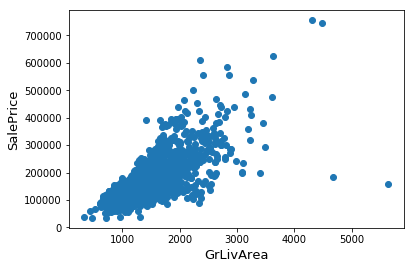

In [50]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

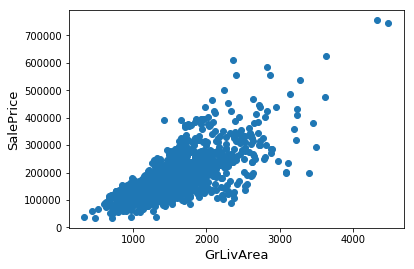

In [51]:
# these two values are outliers.. not follow the regression 
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice'] < 300000)].index)
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [52]:
y_train = np.log1p(y_train)
y_train

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

In [53]:
all_data.shape
# now , we only keep 59 features including numerical and catergorical 

(2919, 56)

In [54]:
# categorical data 
# get_dummies -- convert the catergocial data to indicatior variables 
all_data = pd.get_dummies(all_data)

In [55]:
all_data.describe()

,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,Fireplaces,FullBath,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,...,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,2.860226,0.293555,0.042111,0.389300,1.568003,7.261502,0.261117,0.710829,9.094915,4.212917,...,0.003768,0.001713,0.065091,0.004111,0.008222,0.015759,0.822885,0.083933,0.004111,0.995889
std,0.822693,0.351855,0.167439,0.394826,0.552969,0.324750,0.341563,0.088196,0.509882,0.328868,...,0.061282,0.041359,0.246728,0.063996,0.090317,0.124562,0.381832,0.277335,0.063996,0.063996
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.814131,0.000000,0.000000,7.170888,3.091042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,1.000000,7.027315,0.000000,0.693147,8.919854,4.110874,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,3.000000,0.000000,0.000000,0.693147,2.000000,7.275865,0.000000,0.693147,9.154193,4.262680,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,0.693147,0.000000,0.693147,2.000000,7.464223,0.693147,0.693147,9.356257,4.394449,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,8.000000,1.386294,1.098612,1.609438,4.000000,8.638171,1.098612,1.386294,12.279537,5.749393,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
all_data.shape

(2919, 232)

In [57]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [58]:
train.head()

,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,Fireplaces,FullBath,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,...,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave
0,3,0.693147,0.000000,0.000000,2,7.444833,0.693147,0.693147,9.042040,4.189655,...,0,0,0,0,0,0,1,0,0,1
1,3,0.000000,0.693147,0.693147,2,7.141245,0.000000,0.693147,9.169623,4.394449,...,0,0,0,0,0,0,1,0,0,1
2,3,0.693147,0.000000,0.693147,2,7.488294,0.693147,0.693147,9.328212,4.234107,...,0,0,0,0,0,0,1,0,0,1
3,3,0.693147,0.000000,0.693147,1,7.448916,0.000000,0.693147,9.164401,4.110874,...,0,0,1,0,0,0,0,0,0,1
4,4,0.693147,0.000000,0.693147,2,7.695758,0.693147,0.693147,9.565284,4.442651,...,0,0,0,0,0,0,1,0,0,1


In [59]:
my_model = XGBRegressor(
    n_estimators=500,
    learning_rate= 0.05 , 
    max_depth = 5)
my_model.fit(train,y_train)
xg_predict = my_model.predict(test)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [60]:
xg_predict

array([11.698139, 12.033101, 12.141417, ..., 11.896264, 11.723351,
       12.254333], dtype=float32)

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

In [62]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

In [63]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = 1460))
    return(rmse)

In [64]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [65]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))


In [66]:
from sklearn.linear_model import ElasticNetCV
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))  

In [67]:
from sklearn.svm import SVR
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [68]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

In [69]:
from xgboost import XGBRegressor
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [70]:
from mlxtend.regressor import StackingCVRegressor
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [71]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(train,y_train)

print('elasticnet')
elastic_model_full_data = elasticnet.fit(train, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(train, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(train, y_train)

print('Svr')
svr_model_full_data = svr.fit(train,y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(train, y_train)

print('xgboost')
xgb_model_full_data = xgboost.fit(train, y_train)



START Fit
stack_gen
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [72]:
stack_gen_model_pred = stack_gen_model.predict(np.array(test))

In [73]:
stack_gen_model_pred

array([11.69066 , 12.021545, 12.105742, ..., 11.979696, 11.684472,
       12.261848], dtype=float32)

In [74]:
Actual_Pred_1 = [np.expm1(x) for x in stack_gen_model_pred]

In [75]:
Actual_Pred_1

[119449.875,
 166298.45,
 180906.73,
 195524.84,
 179278.05,
 175425.1,
 169284.98,
 166773.17,
 189030.1,
 116473.45,
 181598.52,
 96745.63,
 97417.89,
 148061.36,
 112678.445,
 406205.75,
 249199.72,
 274410.66,
 270900.62,
 536709.1,
 360804.72,
 212397.22,
 169971.38,
 167521.11,
 181024.44,
 191014.98,
 333517.94,
 225408.3,
 203031.2,
 229047.3,
 189982.89,
 91048.01,
 165204.6,
 275774.1,
 271693.88,
 237211.33,
 167180.52,
 165327.84,
 164429.2,
 158627.83,
 183051.8,
 146533.72,
 307222.62,
 253572.73,
 225891.62,
 190038.7,
 252330.86,
 198463.06,
 164091.62,
 146128.73,
 136284.72,
 162844.92,
 140644.16,
 154997.53,
 188351.5,
 147592.61,
 166013.86,
 123645.45,
 214358.08,
 136488.28,
 138168.05,
 159202.06,
 122745.14,
 128130.305,
 127933.11,
 118831.09,
 100691.53,
 134960.28,
 151920.89,
 179602.16,
 108006.33,
 92048.555,
 138637.94,
 120683.77,
 145200.06,
 116913.59,
 62240.684,
 155781.17,
 186219.62,
 84760.13,
 148196.84,
 148782.69,
 215327.0,
 83714.414,
 11983

In [76]:
elastic_model_pred = elastic_model_full_data.predict(test)

In [77]:
Actual_Pred_2 = [np.expm1(x) for x in elastic_model_pred]

In [78]:
Actual_Pred_2

[114609.05902998301,
 159358.369698586,
 178632.8836701566,
 196100.28925147807,
 195654.3080321634,
 169739.9850613946,
 173885.88486797648,
 161456.58625077672,
 201966.06299076419,
 111725.08269425335,
 184356.02557699088,
 96841.34754888542,
 93527.42121548012,
 141403.46301415184,
 110229.25481484237,
 352222.3871616415,
 240640.27358535558,
 298957.4277007432,
 309827.12340956583,
 470955.9113680764,
 325172.2274206478,
 223758.04365472615,
 181310.90838616574,
 163355.37663770997,
 192289.65403590404,
 194930.8519661467,
 322783.87784367986,
 233061.8631779617,
 192600.1600760747,
 234369.23803242555,
 197697.76997764478,
 93448.2279524596,
 187496.50011542966,
 282895.42120534554,
 282061.787849127,
 236023.98415179778,
 179042.510131878,
 165459.8097630197,
 163481.7196312879,
 156743.6533330295,
 176525.63854447156,
 145102.32039211824,
 276694.83383497526,
 244591.81141518493,
 224898.2101211291,
 193216.92500627355,
 244900.34628813074,
 204899.47920117504,
 162806.11238275

In [79]:
elastic_model_pred

array([11.64929085, 11.97891712, 12.09309365, ..., 12.00208748,
       11.70759478, 12.27574051])

In [80]:
lasso_model_pred = lasso_model_full_data.predict(test)

In [81]:
Actual_Pred_3 = [np.expm1(x) for x in lasso_model_pred]
Actual_Pred_3

[114582.47024325113,
 159347.04541357685,
 178639.54001040035,
 196113.36018366073,
 195632.44931485498,
 169759.9350681601,
 173911.60305767646,
 161468.64154789544,
 202004.17398184282,
 111737.06256991322,
 184499.91191930446,
 96845.8800504856,
 93522.42068904883,
 141437.00920326766,
 110268.5198138655,
 352146.78676007845,
 240592.577556754,
 298892.75473790674,
 309814.7947591864,
 470799.6205136432,
 325153.5792464498,
 223749.0808598016,
 181324.00884964023,
 163343.87523925776,
 192302.48389749802,
 194983.93255609373,
 322695.796702324,
 233116.53470275376,
 192573.405277913,
 234313.66433652863,
 197695.1933547062,
 93414.0977907571,
 187537.7156338165,
 282896.9711423512,
 282064.7468521618,
 235986.84515060694,
 179059.85558158028,
 165455.41187885034,
 163486.1172161749,
 156742.4524903027,
 176468.318618717,
 145125.01187088923,
 276716.13821882586,
 244604.31173708502,
 224874.27524906446,
 193227.60393050747,
 244944.90368153225,
 204916.46345523058,
 162816.425804812

In [82]:
lasso_model_pred

array([11.64905883, 11.97884605, 12.09313091, ..., 12.00200343,
       11.70772525, 12.27601917])

In [83]:
ridge_model_pred = ridge_model_full_data.predict(test)

In [84]:
ridge_model_pred

array([11.6350057 , 11.98579781, 12.08722109, ..., 12.01587183,
       11.71205812, 12.26221187])

In [85]:
Actual_Pred_4 = [np.expm1(x) for x in ridge_model_pred]
Actual_Pred_4

[112983.47547719639,
 160458.65296583326,
 177586.92082305628,
 194823.89188075502,
 192610.64140622725,
 167795.77113476014,
 170233.22587034674,
 160693.99030467522,
 198482.05097041387,
 110562.78195652591,
 178506.44231524173,
 95960.80396446641,
 93315.01621506203,
 141170.22235980938,
 108440.26028122101,
 345163.6617936192,
 240342.73029201425,
 300633.44141990796,
 309767.11968317523,
 478563.0329761383,
 323164.700580193,
 225546.66978933307,
 180715.70305476422,
 166998.50979088296,
 194724.36579784058,
 192934.38946545837,
 323405.6963614264,
 230395.21419091153,
 190672.2154402644,
 236075.21580806485,
 198874.7588060422,
 92163.683742826,
 185265.39057603848,
 282643.9209558205,
 277554.12040944473,
 237638.97873205825,
 177464.21907595682,
 166571.82858309775,
 162550.58393320534,
 154963.13056308884,
 179042.02666374674,
 144907.68718003962,
 271540.0064876925,
 245346.25257761983,
 226757.22294332107,
 192920.8614640381,
 242765.0714664996,
 204278.93267023124,
 161692.

In [86]:
svr_model_pred = svr_model_full_data.predict(test)

In [87]:
svr_model_pred

array([11.68013515, 12.02049547, 12.14157596, ..., 12.02784735,
       11.78760473, 12.24349836])

In [88]:
Actual_Pred_5 = [np.expm1(x) for x in svr_model_pred]
Actual_Pred_5

[118199.20863200806,
 166123.94547725134,
 187506.84494268158,
 201053.23164985943,
 192114.4262792451,
 171220.74217463506,
 175330.50162778603,
 163478.6367831226,
 203225.71319469987,
 113704.8024336719,
 173067.3149276456,
 99322.15411453684,
 96460.13288296641,
 145164.40600374696,
 111222.938734506,
 368562.70265327464,
 239210.80754314444,
 311226.5162949664,
 315384.97737801174,
 495730.95031362504,
 330435.1750929428,
 220829.64594089243,
 182326.88715108228,
 164214.85425733947,
 185051.89479487314,
 193426.573576205,
 324179.1842558848,
 236079.0099706016,
 199978.65289826738,
 240275.63613216224,
 203976.41739103323,
 97404.14262787494,
 193029.96662531982,
 279814.2705979896,
 283667.18634289736,
 235410.91146938203,
 183684.5560645593,
 169418.7264527371,
 165406.78445100816,
 161112.7539459104,
 184129.18230778456,
 140740.8376258835,
 286185.61601632077,
 245843.4417991084,
 227304.54423659274,
 194518.6431345181,
 248434.28887027665,
 210243.6438783363,
 166375.8667187

In [89]:
gbr_model_predict = gbr_model_full_data.predict(test)

In [90]:
gbr_model_predict

array([11.73356736, 12.01914545, 12.14179226, ..., 12.03819223,
       11.66081007, 12.25960479])

In [91]:
Actual_Pred_6 = [np.expm1(x) for x in gbr_model_predict]
Actual_Pred_6

[124686.68360502395,
 165899.82572155516,
 187547.40618087546,
 201168.19311092107,
 186859.81753950563,
 175552.68862336923,
 165987.887183311,
 166483.18808729533,
 184560.33843033272,
 124201.67808300875,
 193587.14395891502,
 92330.50125730068,
 96729.51002973714,
 147725.88124857628,
 120600.84976458753,
 409866.3795274242,
 259916.35098435156,
 281429.6042292429,
 292018.4181170546,
 475303.82061530894,
 353210.1048385427,
 206490.80829319768,
 175047.20158037086,
 170441.15716685844,
 188033.91181734978,
 187900.00660924855,
 328264.0255144995,
 225365.427919156,
 203625.37741515096,
 211644.28548085873,
 194373.1251317077,
 93260.8716097645,
 178603.666711018,
 276248.20977539447,
 281412.414315845,
 240607.40622128083,
 165069.4857354411,
 164743.47365425839,
 169599.09589442404,
 165186.5814847977,
 181107.62521247973,
 147578.2163417225,
 293693.31259438646,
 252370.4874871221,
 225182.28667449995,
 188677.2458949621,
 243957.9654414212,
 200327.90375899215,
 164116.02496970

In [92]:
xgb_model_pred = xgb_model_full_data .predict(test)

In [93]:
xgb_model_pred

array([11.715258, 12.017036, 12.110402, ..., 11.969654, 11.701348,
       12.264642], dtype=float32)

In [94]:
Actual_Pred_7 = [np.expm1(x) for x in xgb_model_pred]
Actual_Pred_7

[122424.46,
 165550.31,
 181751.67,
 195040.25,
 184325.34,
 172145.28,
 174154.89,
 166516.52,
 190812.89,
 120174.76,
 184305.66,
 97064.19,
 96525.18,
 153554.34,
 118418.39,
 397179.12,
 253494.88,
 284137.1,
 288677.7,
 506595.66,
 366228.38,
 213250.69,
 170570.58,
 169246.4,
 180642.11,
 193106.89,
 334242.3,
 228822.64,
 199995.03,
 221637.0,
 191367.25,
 93131.12,
 175192.88,
 282374.22,
 282425.66,
 232163.12,
 173689.31,
 160378.66,
 156999.84,
 151570.69,
 180347.92,
 144377.8,
 303168.25,
 245951.4,
 226200.97,
 192430.72,
 259377.45,
 199233.56,
 158267.73,
 139781.67,
 137826.39,
 167313.86,
 138771.94,
 143099.8,
 188872.6,
 149056.08,
 169277.88,
 132935.45,
 216828.83,
 133580.53,
 135448.97,
 159071.39,
 116552.12,
 126143.336,
 125976.47,
 117501.21,
 97388.72,
 139230.33,
 148938.7,
 180862.23,
 108428.95,
 97170.8,
 137308.69,
 118580.445,
 151398.33,
 114441.32,
 61885.965,
 164786.5,
 182570.25,
 82583.01,
 142915.0,
 143316.27,
 219017.66,
 77761.64,
 109914.76

In [95]:
# combined_predic = .1*elastic_model_pred+0.1*lasso_model_pred+0.1*ridge_model_pred 
# +0.1*svr_model_pred +0.15*gbr_model_predict+0.05*xgb_model_pred+0.4*stack_gen_model_pred

In [96]:
combined_predic = .1*elastic_model_pred+0.05*lasso_model_pred+0.1*ridge_model_pred+0.1*svr_model_pred+0.1*gbr_model_predict+0.15*xgb_model_pred+0.4*stack_gen_model_pred

In [97]:
Actual_Pred_8 = [np.expm1(x) for x in combined_predic]
Actual_Pred_8

[118871.38820325174,
 164480.19342801633,
 181657.22326670415,
 196573.01987670158,
 185757.07703350834,
 172888.3513092287,
 171052.16091950648,
 164953.79461708397,
 193055.95726202882,
 116155.38614289557,
 182396.26392158354,
 96531.7364773388,
 96111.90712207773,
 146823.70722834626,
 113337.89944008441,
 386440.18428875506,
 247662.29258006465,
 286269.3070202105,
 289322.24528604106,
 505534.02339891455,
 348290.73938105727,
 215714.12937707198,
 174502.3812569145,
 167049.11360555017,
 185057.94645071062,
 192030.40479413734,
 329506.12663893437,
 228602.19716654028,
 199472.9015873587,
 228682.62134746544,
 194019.5793390442,
 92668.8679963829,
 175881.83146988068,
 278952.33921819564,
 277568.0312742757,
 236465.94480141663,
 172294.2866473378,
 165063.43398454494,
 163566.38887613616,
 157781.38637862715,
 181159.82414521812,
 145347.65565198413,
 294695.3475943739,
 249335.17263916266,
 225943.70296869334,
 191466.13243838583,
 250035.54312469045,
 201454.98409741293,
 1630

In [98]:
# cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
#            for alpha in alphas]
# # in order to get a good alpha

In [99]:
# cv_ridge = pd.Series(cv_ridge, index = alphas)

In [100]:
# cv_ridge = pd.Series(cv_ridge, index = alphas)
# cv_ridge.plot(title = "Validation")
# plt.xlabel("alpha")
# plt.ylabel("rmse")

In [101]:
# from sklearn import linear_model
# clf = linear_model.Ridge (alpha = 4)
# clf.fit(train , y_train)


In [102]:
# model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train, y_train)
# # It's linear model.. not sure, we only can contain numerical data and can not contain cater.

In [103]:
# lasso_predic = model_lasso.predict(test)

In [104]:
# predictions = pd.DataFrame({"xgb":xg_predict, "lasso":lasso_predic})
# predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [105]:
# xg_predict

In [106]:
# len(xg_predict)

In [107]:
# lasso_predic

In [108]:
# len(lasso_predic)

In [109]:
# combined_predic = 0.1*xg_predict+lasso_predic*.9

In [110]:
# test_pred = combined_predic

In [111]:
# print(len(test_pred))

In [112]:
# Actual_Pred = 0.2*Actual_Pred_1+.1*Actual_Pred_2+0.2*Actual_Pred_3+.1*Actual_Pred_4+.3*Actual_Pred_5+.05*Actual_Pred_6+0.3*Actual_Pred_7
# Actual_Pred

In [113]:
test["SalePrice"] = Actual_Pred_8

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [114]:
test.columns

Index(['BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces',
       'FullBath', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage',
       ...
       'RoofStyle_Shed', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'Street_Grvl', 'Street_Pave', 'SalePrice'],
      dtype='object', length=233)

In [115]:
test['Id'] = list(test_house_Id)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [116]:
list(test_house_Id)

[1461,
 1462,
 1463,
 1464,
 1465,
 1466,
 1467,
 1468,
 1469,
 1470,
 1471,
 1472,
 1473,
 1474,
 1475,
 1476,
 1477,
 1478,
 1479,
 1480,
 1481,
 1482,
 1483,
 1484,
 1485,
 1486,
 1487,
 1488,
 1489,
 1490,
 1491,
 1492,
 1493,
 1494,
 1495,
 1496,
 1497,
 1498,
 1499,
 1500,
 1501,
 1502,
 1503,
 1504,
 1505,
 1506,
 1507,
 1508,
 1509,
 1510,
 1511,
 1512,
 1513,
 1514,
 1515,
 1516,
 1517,
 1518,
 1519,
 1520,
 1521,
 1522,
 1523,
 1524,
 1525,
 1526,
 1527,
 1528,
 1529,
 1530,
 1531,
 1532,
 1533,
 1534,
 1535,
 1536,
 1537,
 1538,
 1539,
 1540,
 1541,
 1542,
 1543,
 1544,
 1545,
 1546,
 1547,
 1548,
 1549,
 1550,
 1551,
 1552,
 1553,
 1554,
 1555,
 1556,
 1557,
 1558,
 1559,
 1560,
 1561,
 1562,
 1563,
 1564,
 1565,
 1566,
 1567,
 1568,
 1569,
 1570,
 1571,
 1572,
 1573,
 1574,
 1575,
 1576,
 1577,
 1578,
 1579,
 1580,
 1581,
 1582,
 1583,
 1584,
 1585,
 1586,
 1587,
 1588,
 1589,
 1590,
 1591,
 1592,
 1593,
 1594,
 1595,
 1596,
 1597,
 1598,
 1599,
 1600,
 1601,
 1602,
 1603,

In [117]:
for i in test.columns:
    print(i)

BedroomAbvGr
BsmtFullBath
BsmtHalfBath
Fireplaces
FullBath
GrLivArea
HalfBath
KitchenAbvGr
LotArea
LotFrontage
LowQualFinSF
MSSubClass
MasVnrArea
MiscVal
MoSold
OverallCond
OverallQual
PoolArea
TotRmsAbvGrd
YearBuilt
YearRemodAdd
YrSold
total_SF
total_outdoor_sf
BldgType_1Fam
BldgType_2fmCon
BldgType_Duplex
BldgType_Twnhs
BldgType_TwnhsE
BsmtCond_Fa
BsmtCond_Gd
BsmtCond_None
BsmtCond_Po
BsmtCond_TA
BsmtExposure_Av
BsmtExposure_Gd
BsmtExposure_Mn
BsmtExposure_No
BsmtExposure_None
BsmtFinType1_ALQ
BsmtFinType1_BLQ
BsmtFinType1_GLQ
BsmtFinType1_LwQ
BsmtFinType1_None
BsmtFinType1_Rec
BsmtFinType1_Unf
BsmtFinType2_ALQ
BsmtFinType2_BLQ
BsmtFinType2_GLQ
BsmtFinType2_LwQ
BsmtFinType2_None
BsmtFinType2_Rec
BsmtFinType2_Unf
BsmtQual_Ex
BsmtQual_Fa
BsmtQual_Gd
BsmtQual_None
BsmtQual_TA
CentralAir_N
CentralAir_Y
Condition1_Artery
Condition1_Feedr
Condition1_Norm
Condition1_PosA
Condition1_PosN
Condition1_RRAe
Condition1_RRAn
Condition1_RRNe
Condition1_RRNn
Condition2_Artery
Condition2_Feedr
Condit

In [118]:
final_data = test[['Id','SalePrice']]

In [119]:
final_data.reset_index(drop=True)

,Id,SalePrice
0,1461,118871.388203
1,1462,164480.193428
2,1463,181657.223267
3,1464,196573.019877
4,1465,185757.077034
5,1466,172888.351309
6,1467,171052.160920
7,1468,164953.794617
8,1469,193055.957262
9,1470,116155.386143


In [120]:
final_data.head()

,Id,SalePrice
1460,1461,118871.388203
1461,1462,164480.193428
1462,1463,181657.223267
1463,1464,196573.019877
1464,1465,185757.077034


In [121]:
final_data.to_csv("Hourse price Prediction_c.csv" ,index = False)